You can use MCMC to solve these problems. But it’s not required.
1. Revisit the marriage, age, and happiness collider bias example from Chap-
ter 6. Run models m6.9 and m6.10 again (pages 178–179). Compare these
two models using both PSIS and WAIC. Which model is expected to make
better predictions, according to these criteria, and which model yields the
correct causal inference?


In [26]:
import pandas as pd
from pathlib import Path
import pymc3 as pm
import arviz as az

path_happy = Path("week04", "happiness.csv")
df_happy = pd.read_csv(path_happy)

df_happy["mid"] = df_happy["married"]

In [27]:
df_happy.head()

,age,married,happiness,A,mid
0,65,0,-2.000000,1.0,0
1,65,0,-1.789474,1.0,0
2,65,1,-1.578947,1.0,1
3,65,0,-1.368421,1.0,0
4,65,0,-1.157895,1.0,0


In [3]:
mid = df_happy["mid"].values
happiness = df_happy["happiness"].values
A = df_happy["A"].values

with pm.Model() as model_6_9:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=2)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", 1)

    # Expected value of outcome
    mu = alpha[mid] + beta * A

    # Likelihood (sampling distribution) of observations
    happiness_like = pm.Normal("happiness_like", mu=mu, sigma=sigma, observed=happiness)

    # Inference!
    trace_6_9 = pm.sample(1000, tune=1000)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


In [4]:
mid = df_happy["mid"].values
happiness = df_happy["happiness"].values
A = df_happy["A"].values

with pm.Model() as model_6_10:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", 1)

    # Expected value of outcome
    mu = alpha + beta * A

    # Likelihood (sampling distribution) of observations
    happiness_like = pm.Normal("happiness_like", mu=mu, sigma=sigma, observed=happiness)

    # Inference!
    trace_6_10 = pm.sample(1000, tune=1000)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.8871203757056552, but should be close to 0.8. Try to increase the number of tuning steps.


In [5]:
az.loo(trace_6_9, model_6_9)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 4000 posterior samples and 960 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1356.93    18.65
p_loo        3.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      960  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [29]:
az.loo(trace_6_10, model_6_10)
az.waic(trace_6_10, model_6_10)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 4000 posterior samples and 960 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1551.02    13.78
p_waic        2.37        -

### Solution

The dag is:
A -> M
H -> M

Conditioning on M gives us better LOO results, but the inference is wrong (condtioning on a collider, common consequence of age and happiness, we are inducing an spurious correlation).

2. Reconsider the urban fox analysis from last week’s homework. On the
basis of PSIS and WAIC scores, which combination of variables best predicts
body weight (W, weight)? What causal interpretation can you assign each
coefficient (parameter) from the best scoring model?


In [12]:
foxes = pd.read_csv(Path('week03') /'foxes.csv', sep=";")

In [13]:
from itertools import combinations
from itertools import chain

# All subsets of a list, except the empty set
def subsets(lst):
    return chain(*map(lambda x: combinations(lst, x), range(1, len(lst)+1)))
subsets_cols = list(subsets(["groupsize", "area", "avgfood"]))

# create dictionary of subsets
subsets_dict = {}
for i in subsets_cols:
    subsets_dict["_".join(i)] = i

In [30]:
subsets_dict

{'groupsize': ('groupsize',),
 'area': ('area',),
 'avgfood': ('avgfood',),
 'groupsize_area': ('groupsize', 'area'),
 'groupsize_avgfood': ('groupsize', 'avgfood'),
 'area_avgfood': ('area', 'avgfood'),
 'groupsize_area_avgfood': ('groupsize', 'area', 'avgfood')}

In [15]:
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [17]:
models = {}
traces = {}
for key, cols in subsets_dict.items():
    print(key, cols)

    with pm.Model() as models[key]:
        # Priors for unknown model parameters
        alpha = pm.Normal("alpha", mu=0, sigma=1)
        betas = []
        for i in range(3):
            betas.append(pm.Normal(f"beta_{i}", mu=0, sigma=1))
        sigma = pm.Exponential("sigma", 1)

        # Expected value of outcome
        mu = alpha
        for i, col in enumerate(cols):
            mu += betas[i] * foxes[col].values

        # Likelihood (sampling distribution) of observations
        happiness_like = pm.Normal("happiness_like", mu=mu, sigma=sigma, observed=foxes.weight.values)

        # Inference!
        traces[key] = pm.sample(1000, tune=1000)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [20]:
for key, cols in subsets_dict.items():
    print(key, cols)
    print(az.loo(traces[key], models[key]))

Got error No model on context stack. trying to find log_likelihood in translation.


groupsize ('groupsize',)


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -186.27     6.79
p_loo        2.69        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

area ('area',)


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -187.67     6.59
p_loo        2.62        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

avgfood ('avgfood',)


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -187.14     6.56
p_loo        2.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

groupsize_area ('groupsize', 'area')


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -182.57     7.67
p_loo        3.65        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

groupsize_avgfood ('groupsize', 'avgfood')


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -182.71     7.21
p_loo        3.24        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

area_avgfood ('area', 'avgfood')


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -187.94     6.61
p_loo        2.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

groupsize_area_avgfood ('groupsize', 'area', 'avgfood')


/Users/davidmasip/Documents/Others/stats-rethinking/.venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Computed from 4000 posterior samples and 116 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -181.78     7.73
p_loo        4.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      116  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



/var/folders/ff/3y2196b13bq0nbm3_ms25nyh0000gp/T/ipykernel_63454/3735708912.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(traces["groupsize_area_avgfood"], figsize=(12, 12))


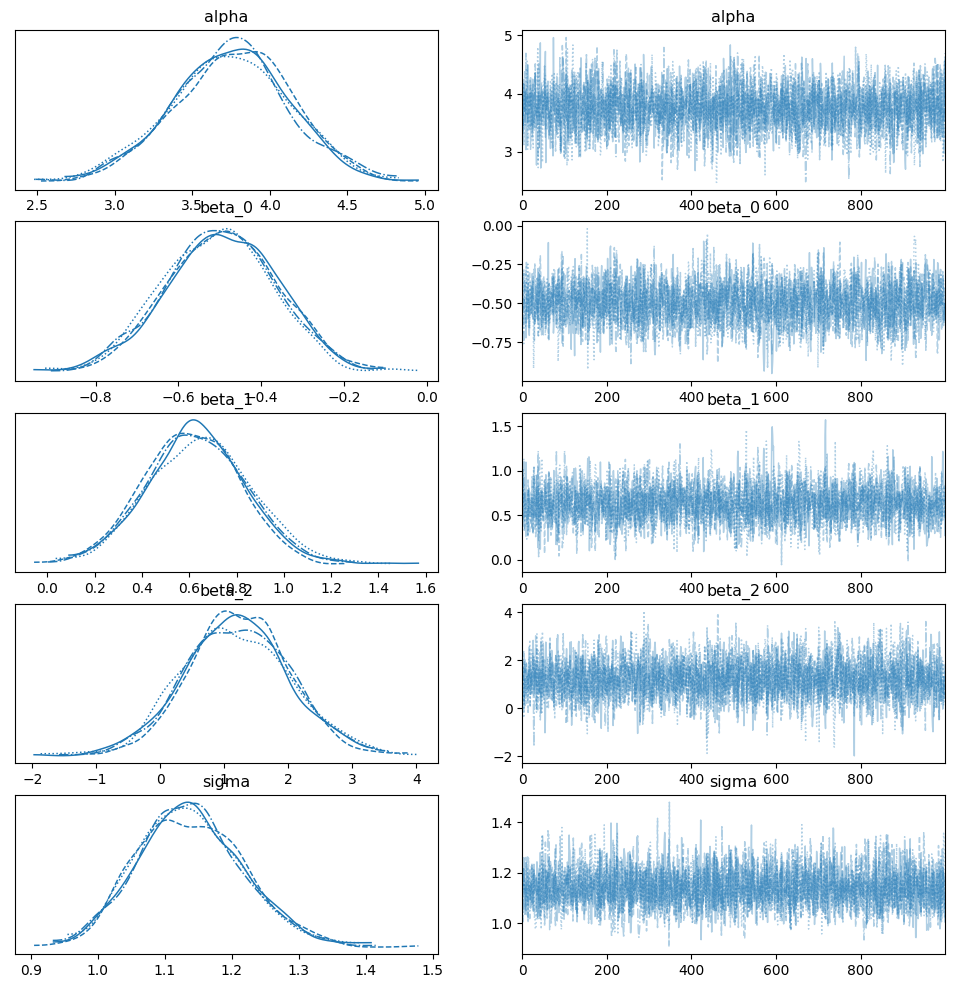

In [25]:
with models["groupsize_area_avgfood"]:
    pm.traceplot(traces["groupsize_area_avgfood"], figsize=(12, 12))

Causal interpretations:
* area: direct effect
* avgfood: direct effect
* groupsize: total effect

3. Build a predictive model of the relationship show on the cover of the book,
the relationship between the timing of cherry blossoms and March temper-
ature in the same year. The data are found in data(cherry_blossoms).
Consider at least two different models (functional relationships) to predict
doy with temp. You could for example compare a linear model with a qua-
dratic model. Compare them with PSIS or WAIC.
Suppose March temperatures reach 9 degrees by the year 2050. What does
your best model predict for the predictive distribution of the day-in-year that
the cherry trees will blossom?


4-OPTIONALCHALLENGE. The data in data(Dinosaurs)are body mass
estimates at different estimated ages for six different dinosaur species. See
?Dinosaurs for more details. Choose one or more of these species (at least
one, but as many as you like) and model its growth. To be precise: Make
a predictive model of body mass using age as a predictor. Consider two or
more model types for the function relating age to body mass and score each
using PSIS and WAIC.
Which model do you think is best, on predictive grounds? On scientific
grounds? If your answers to these questions differ, why?
This is a challenging exercise, because the data are so scarce. But it is also a
realistic example, because people publish Nature papers with even less data.
So do your best, and I look forward to seeing your growth curves.
1